In [125]:
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
import matplotlib.pyplot as plt

In [289]:
class SMOModel:
    def __init__(self , X , y , kernel=np.dot,C=1000,tol=0.01,eps=0.01):
        self.tol=0.01
        self.eps=0.01
        self.X = X
        y[y==0]=-1
        self.target = y
        self.LM = np.zeros(len(X))
        self.b = 0
        self.kernel = kernel
        self.Errors = np.zeros(len(X))
        self.m = len(X)
        self.C = C
        self.W = np.zeros(X.shape[1])
        self.objective = []
        for i in np.arange(len(X)):
            self.Errors[i] = self.kernel(self.W,self.X[i]) - self.b - self.target[i]
        
    def predict(X):
        return np.sign(self.kernel(X,self.W)-self.b)

In [277]:
def takeStep(i1,i2,model):
    if(i1==i2):
        return 0 , model
    alph1 = model.LM[i1]
    alph2 = model.LM[i2]
    y1 = model.target[i1]
    y2 = model.target[i2]
    E1 = model.Errors[i1]
    E2 = model.Errors[i2]
    s = y1*y2
    if(s<0):
        L = max(0 , alph2 - alph1)
        H = min(model.C , model.C + alph2 - alph1)
    else:
        L = max(0 , alph2 + alph1 - model.C)
        H = min(model.C , alph2 + alph1)
    if(L==H):
        return 0 , model
    K11 = model.kernel(model.X[i1],model.X[i1])
    K12 = model.kernel(model.X[i1],model.X[i2])
    K22 = model.kernel(model.X[i2],model.X[i2])
    eta = K11+K22-2*K12
    if(eta>0):
        a2 = alph2 + y2*(E1-E2)/eta
        if(a2<L):
            a2 = L
        elif(a2>H):
            a2 = H
    else:
        return 0,model

    if a2 < 1e-5:
        a2 = 0.0
    elif a2 > (model.C - 1e-5):
        a2 = model.C
    
    
    if ((np.abs(a2 - alph2)) < (model.eps * (a2 + alph2 + model.eps))):
        return 0, model
        
    a1 = alph1 + s*(alph2-a2)
    
    h=model.b
    delb1 = E1 + y1*(a1-alph1)*K11 + y2*(a2-alph2)*K12 + model.b
    delb2 = E2 + y1*(a1-alph1)*K12 + y2*(a2-alph2)*K22 + model.b
    if (0>a1 or a1>model.C):
        model.b = delb1
    elif(0>a2 or a2>model.C):
        model.b = delb2
    else:
        model.b = (delb1+delb2)/2


    model.LM[i1] = a1
    model.LM[i2] = a2
    
    for index, alph in zip([i1, i2], [a1, a2]):
        if 0 < alph < model.C:
            model.Errors[index] = 0
     
    for i in range(model.m):
        if ((i!=i1) or (i!=i2)):
            model.Errors[i] = model.Errors[i] + y1*(a1-alph1)*model.kernel(model.X[i],model.X[i1]) + y2*(a2-alph2)*model.kernel(model.X[i],model.X[i2])+h-model.b
    return 1 , model

In [278]:
#examine function
def examine(i2,model):
    y2 = model.target[i2]
    alph2 = model.LM[i2]
    E2 = model.Errors[i2]
    r2 = E2*y2
    if((r2<-model.tol and alph2 <model.C) or (r2 > model.tol and alph2>0)):
        if(len(model.LM[(model.LM!=0) & (model.LM!=model.C)])>1):
            if model.Errors[i2] > 0:
                i1 = np.argmin(model.Errors)
            elif model.Errors[i2] <= 0:
                i1 = np.argmax(model.Errors)
            tvalue, model = takeStep(i1,i2,model)
            if tvalue:
                return 1 , model
        NI = np.roll(np.where((model.LM!=0) & (model.LM!=model.C)),np.random.choice(np.arange(model.m)))
        for i1 in NI[0]:
            tvalue, model = takeStep(i1,i2,model)
            if tvalue:
                return 1,model
        for i1 in np.roll(np.arange(model.m), np.random.choice(np.arange(model.m))):
            tvalue,model = takeStep(i1,i2,model)
            if tvalue:
                return 1,model
    return 0 , model

In [279]:
def objfunc(model):
    h=0
    k=0
    for i in np.arange(model.m):
        for j in np.arange(model.m):
            h+=(model.LM[i]*model.LM[j]*model.target[i]*model.target[j]*model.kernel(X[i],X[j]))
    for i in model.LM:
        k+=i
    return k-0.5*h

In [280]:
def train(model):
    numChanged = 0
    examineAll = 1;
    while((numChanged>0) or (examineAll)):
        numChanged=0
        if(examineAll):
            for i in np.arange(model.m):
                h,model = examine(i,model)
                numChanged+=h
                model.objective.append(objfunc(model))
                #print("the ojc func is:",model.objective[-1:])
                if((len(model.objective)>=5) and model.objective[-1] == model.objective[-5] ):
                    for i in np.arange(model.m):
                        model.W = model.W + model.X[i]*model.target[i]*model.LM[i]
                    return model
        else:
            for i,q in enumerate((model.LM!=0) & (model.LM!=model.C)):
                if q:
                    h,model = examine(i,model)
                    numChanged+=h
                    model.objective.append(objfunc(model))
                    #print("the ojc func is:",model.objective[-1:])
                    if((len(model.objective)>=5) and model.objective[-1] == model.objective[-5]):
                        for i in np.arange(model.m):
                            model.W = model.W + model.X[i]*model.target[i]*model.LM[i]
                        return model
        if(examineAll == 1):
            examineAll = 0
        elif(numChanged==0):
            examineAll = 1
    return model

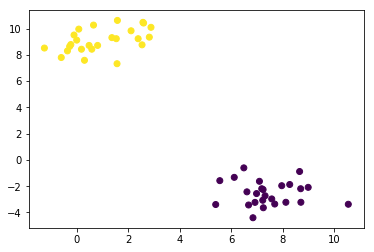

In [281]:
#Generating TOY data
X, y= make_blobs(n_samples=50,centers=2,n_features=2,random_state=32)
plt.scatter(X[:,0],X[:,1],c=y)

In [282]:
model1 = SMOModel(X,y)

In [283]:
model1.Errors

array([ 1.,  1., -1.,  1.,  1., -1., -1.,  1., -1.,  1., -1., -1., -1.,
        1., -1.,  1.,  1., -1., -1.,  1., -1., -1.,  1.,  1., -1.,  1.,
        1.,  1.,  1., -1., -1., -1.,  1., -1.,  1., -1.,  1.,  1.,  1.,
        1., -1., -1., -1., -1.,  1.,  1.,  1., -1., -1., -1.])

In [284]:
model1=train(model1)

In [285]:
print(model1.W)
print(model1.b)

[-0.08194912  0.18602723]
0.35612293111233795


In [286]:
from sklearn.svm import LinearSVC
clf = LinearSVC(C=1000,tol=0.01)
clf.fit(X,y)

LinearSVC(C=1000, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.01,
     verbose=0)

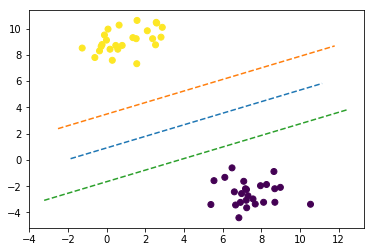

In [287]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')
plt.scatter(X[:,0],X[:,1],c=y)

abline(-model1.W[0]/model1.W[1],model1.b/W[1])
abline(-model1.W[0]/model1.W[1],(model1.b+1)/W[1])
abline(-model1.W[0]/model1.W[1],(model1.b-1)/W[1])

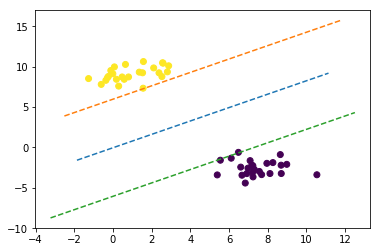

In [288]:
plt.scatter(X[:,0],X[:,1],c=y)
abline(-clf.coef_[0][0]/clf.coef_[0][1],clf.intercept_/clf.coef_[0][1])
abline(-clf.coef_[0][0]/clf.coef_[0][1],(clf.intercept_+1)/clf.coef_[0][1])
abline(-clf.coef_[0][0]/clf.coef_[0][1],(clf.intercept_-1)/clf.coef_[0][1])